In [2]:
import os
import pandas as pd
import numpy as np
# When loading the tf library the kernel crashes in VSCode
# https://github.com/microsoft/vscode-jupyter/wiki/Kernel-crashes-when-using-tensorflow
# import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.style.use('default')
np.random.seed(3000)

# Set style parameters for publication quality
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 14,
    'axes.linewidth': 1.2,
    'axes.labelpad': 8,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'legend.frameon': True,
    'legend.fontsize': 13,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    # 'savefig.dpi': 300,
    # 'savefig.bbox': 'tight',
    'savefig.transparent': True
})

sns.set(style="ticks")
plt.rcParams['text.usetex'] = False

# set tf to be run on CPUs
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
%load_ext line_profiler

/tmp/ipykernel_341165/3459016294.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def load_training_data(csv_path):
    """
    Load real training statistics data from CSV file.
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file containing training statistics
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the loaded training data with error values
    """
    try:
        df = pd.read_csv(csv_path)
        print(f"Successfully loaded data from {csv_path}")
        print(f"Data shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        
        # Convert string columns to numeric if needed
        numeric_cols = ['n_neurons', 'n_edges', 'batch_size', 'seq_len', 
                        'mean_step_time', 'sem_step_time', 
                        'mean_gpu_memory', 'sem_gpu_memory',
                        'mean_rate', 'sem_rate']
        
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                
        # If we have SEM values already, use them directly
        if 'sem_step_time' in df.columns and 'sem_gpu_memory' in df.columns:
            # Data already has error values
            pass
        else:
            # Group by configuration parameters and calculate statistics
            print("Computing statistics from raw data...")
            grouped = df.groupby(['sim_name', 'n_neurons', 'n_edges', 'batch_size', 'seq_len', 'mode']).agg({
                'mean_step_time': ['mean', 'sem'],
                'mean_gpu_memory': ['mean', 'sem'],
                'mean_rate': ['mean', 'sem']
            }).reset_index()
            
            # Flatten multi-level column names
            grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
            df = grouped
            
        # Print some statistics about the dataset
        print(f"Unique neuron counts: {sorted(df['n_neurons'].unique())}")
        print(f"Unique batch sizes: {sorted(df['batch_size'].unique())}")
        print(f"Unique sequence lengths: {sorted(df['seq_len'].unique())}")
        if 'mode' in df.columns:
            print(f"Modes: {sorted(df['mode'].unique())}")
        
        return df
        
    except Exception as e:
        print(f"Error loading data: {e}")
        # Return an empty DataFrame with the expected columns
        return pd.DataFrame(columns=['n_neurons', 'n_edges', 'batch_size', 'seq_len', 
                                    'mean_step_time', 'sem_step_time',
                                    'mean_gpu_memory', 'sem_gpu_memory',
                                    'mean_rate', 'sem_rate', 'mode'])

# path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/performance_figures/performance_statistics_thesis_data.csv'
path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/performance_figures/performance_statistics_paper_data.csv'

# open as pd dataframe
df = load_training_data(path)
# Rename columns to match the expected format in the plot functions
df = df.rename(columns={
    'n_neurons': 'neurons',
    'mean_step_time': 'step_time', 
    'sem_step_time': 'step_time_sem',
    'mean_gpu_memory': 'memory',
    'sem_gpu_memory': 'memory_sem'
})

# Separate train and test data
train_df = df[df['mode'] == 'train']
test_df = df[df['mode'] == 'test']

train_df

Successfully loaded data from /home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/performance_figures/performance_statistics_paper_data.csv
Data shape: (14, 12)
Columns: ['sim_name', 'n_neurons', 'n_edges', 'batch_size', 'seq_len', 'mean_rate', 'sem_rate', 'mean_step_time', 'sem_step_time', 'mean_gpu_memory', 'sem_gpu_memory', 'mode']
Unique neuron counts: [1000, 5000, 10000, 20000, 40000, 65871, 203816]
Unique batch sizes: [1, 10]
Unique sequence lengths: [1000, 4000]
Modes: ['test', 'train']


,sim_name,neurons,n_edges,batch_size,seq_len,mean_rate,sem_rate,step_time,step_time_sem,memory,memory_sem,mode
0,b_on0m,1000,544263,1,1000,0.0037,0.0,4.0264,0.0054,1.8926,0.0072,train
1,b_y7bf,5000,3074601,1,1000,0.0036,0.0,4.3592,0.0052,1.6511,0.0026,train
2,b_ubco,10000,6645432,1,1000,0.0036,0.0,4.4366,0.0053,2.7256,0.0015,train
3,b_aeym,20000,14807994,1,1000,0.0036,0.0,4.9276,0.0065,4.6116,0.0016,train
4,b_gh6y,40000,31863080,1,1000,0.0036,0.0,6.0974,0.0061,8.8211,0.0022,train
10,b_k2zc,65871,54378241,1,1000,0.0037,0.0,8.1367,0.0065,14.3594,0.0033,train
12,b_g0i6,203816,179735332,1,1000,0.0030,0.0,19.0208,0.0104,43.6048,0.0264,train


LINEAR FIT IN LOG-LOG SPACE
Power law form: y = a × x^b
  Coefficient (a) = 2.754406e+02
  Exponent (b)    = 1.097537
  R² = 0.999843


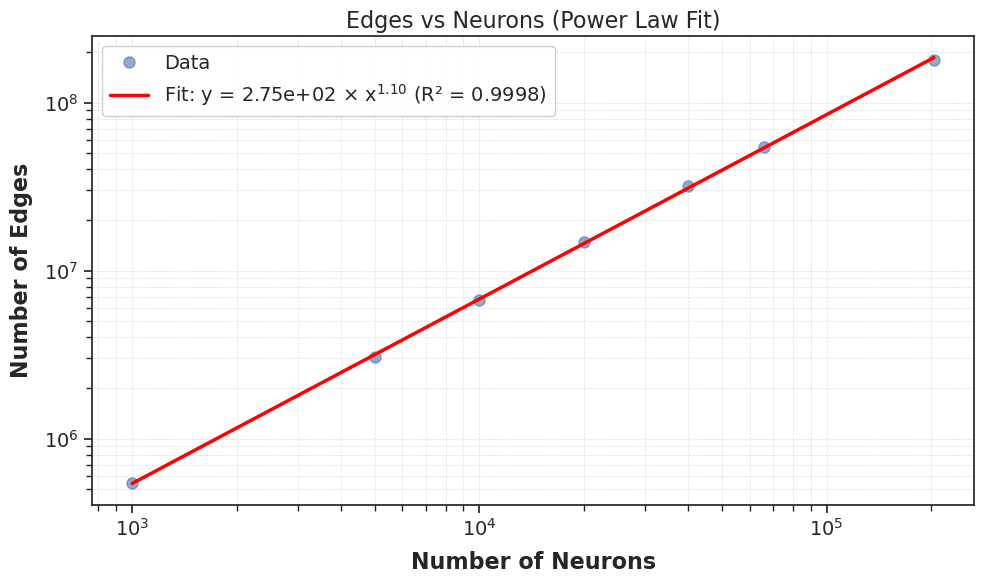

In [4]:
from scipy.optimize import curve_fit

n_neurons = train_df['neurons'].values
n_edges = train_df['n_edges'].values

plt.figure(figsize=(10, 6))
plt.plot(n_neurons, n_edges, 'o', alpha=0.6, label='Data', markersize=8)

mask = n_neurons > 0

# Perform linear fit in log-log space: log(y) = b*log(x) + log(a)
# This corresponds to a power law: y = a * x^b
log_neurons = np.log10(n_neurons[mask])
log_edges = np.log10(n_edges[mask])

# Linear fit in log space
fit_params = np.polyfit(log_neurons, log_edges, 1)
b, log_a = fit_params  # slope and intercept in log space
a = 10**log_a  # convert back to linear space

# Calculate R-squared
log_edges_fit = b * log_neurons + log_a
residuals = log_edges - log_edges_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((log_edges - np.mean(log_edges))**2)
r_squared = 1 - (ss_res / ss_tot)

print("=" * 60)
print("LINEAR FIT IN LOG-LOG SPACE")
print("=" * 60)
print(f"Power law form: y = a × x^b")
print(f"  Coefficient (a) = {a:.6e}")
print(f"  Exponent (b)    = {b:.6f}")
print(f"  R² = {r_squared:.6f}")
print("=" * 60)

# Generate fit curve
x_fit = np.logspace(np.log10(min(n_neurons[mask])), np.log10(max(n_neurons[mask])), 100)
y_fit = a * x_fit**b

plt.plot(x_fit, y_fit, '-', linewidth=2.5, color='red', 
         label=f'Fit: y = {a:.2e} × x$^{{{b:.2f}}}$ (R² = {r_squared:.4f})')

plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14, frameon=True, fancybox=True, framealpha=0.95, loc='upper left')
plt.xlabel('Number of Neurons', fontsize=16, fontweight='bold')
plt.ylabel('Number of Edges', fontsize=16, fontweight='bold')
plt.title('Edges vs Neurons (Power Law Fit)', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.show()

In [5]:
train_seq1000 = train_df[train_df['seq_len'] == 1000] if 'seq_len' in train_df.columns else pd.DataFrame()
# filter by batch size 1
train_seq1000 = train_seq1000[train_seq1000['batch_size'] == 1] if 'batch_size' in train_seq1000.columns else pd.DataFrame()
train_seq1000

,sim_name,neurons,n_edges,batch_size,seq_len,mean_rate,sem_rate,step_time,step_time_sem,memory,memory_sem,mode
0,b_on0m,1000,544263,1,1000,0.0037,0.0,4.0264,0.0054,1.8926,0.0072,train
1,b_y7bf,5000,3074601,1,1000,0.0036,0.0,4.3592,0.0052,1.6511,0.0026,train
2,b_ubco,10000,6645432,1,1000,0.0036,0.0,4.4366,0.0053,2.7256,0.0015,train
3,b_aeym,20000,14807994,1,1000,0.0036,0.0,4.9276,0.0065,4.6116,0.0016,train
4,b_gh6y,40000,31863080,1,1000,0.0036,0.0,6.0974,0.0061,8.8211,0.0022,train
10,b_k2zc,65871,54378241,1,1000,0.0037,0.0,8.1367,0.0065,14.3594,0.0033,train
12,b_g0i6,203816,179735332,1,1000,0.0030,0.0,19.0208,0.0104,43.6048,0.0264,train


/tmp/ipykernel_341165/3967916033.py:101: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  ax_inset = inset_axes(ax1, width="40%", height="40%", loc='upper left',
/tmp/ipykernel_341165/3967916033.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0)


Training linear fit: y = 7.46e-05x + 3.60e+00
Testing linear fit: y = 3.04e-05x + 6.98e-01


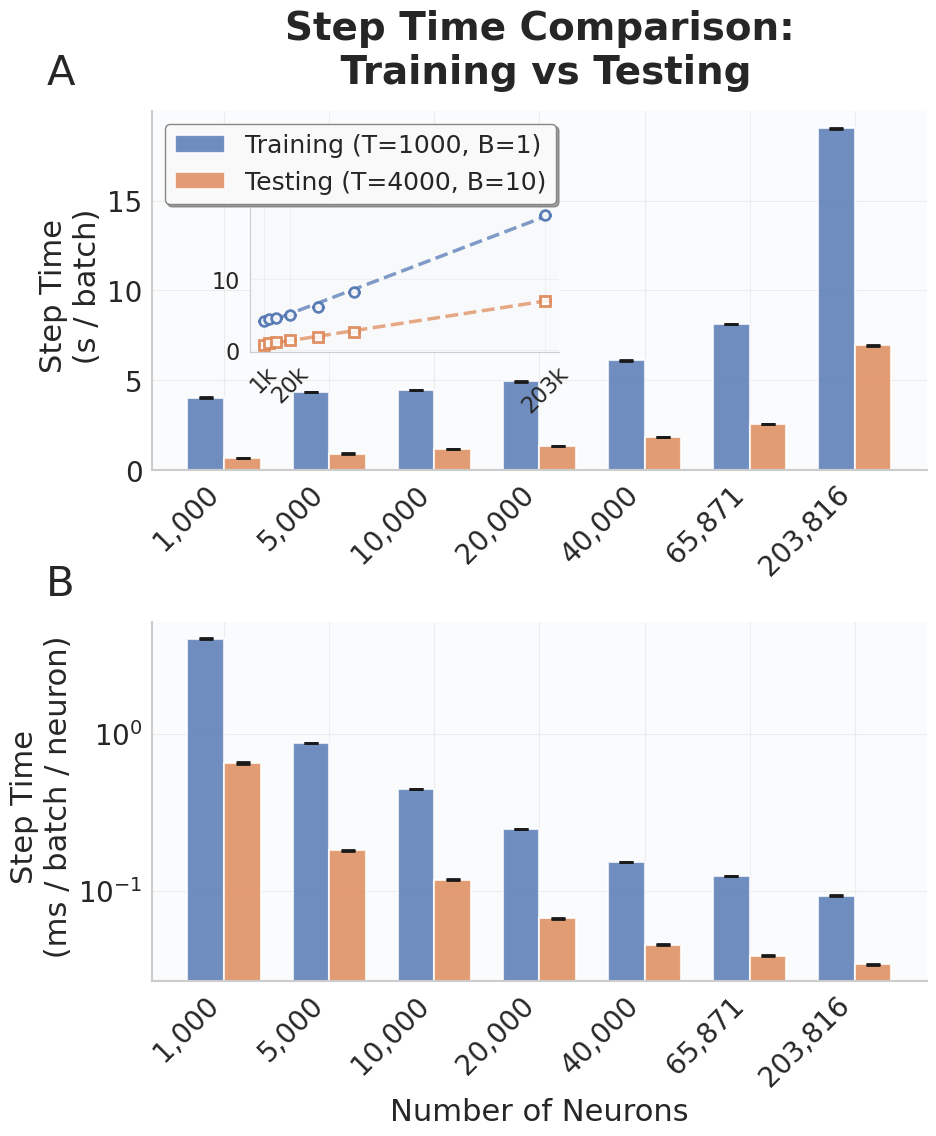

In [6]:
def create_normalized_step_time_comparison(train_df, test_df, output_dir=''):
    """
    Create a specialized comparison between train and test data for sequence length 4000,
    with step time normalized by batch size to provide a fair comparison.
    
    Parameters:
    -----------
    train_df : pandas.DataFrame
        DataFrame containing the training data
    test_df : pandas.DataFrame
        DataFrame containing the testing data
    output_dir : str
        Directory to save the generated figures
    """
    # Set publication-ready style
    plt.style.use('default')
    sns.set_style("whitegrid", {"axes.spines.right": False, "axes.spines.top": False})
    sns.set_palette("deep")
    
    # Create output directory if it doesn't exist
    # os.makedirs(output_dir, exist_ok=True)
    # Filter for sequence length 1000 in training data
    train_seq1000 = train_df[train_df['seq_len'] == 1000] if 'seq_len' in train_df.columns else pd.DataFrame()
    train_seq1000 = train_seq1000[train_seq1000['batch_size'] == 1] if 'batch_size' in train_seq1000.columns else pd.DataFrame()

    # Prepare test data (might not have seq_len column if it's constant)
    test_data = test_df.copy()
    # Normalize step times by batch size for fair comparison
    if not train_seq1000.empty:
        train_seq1000['normalized_step_time'] = train_seq1000['step_time'] / train_seq1000['batch_size']
        train_seq1000['normalized_step_time_sem'] = train_seq1000['step_time_sem'] / train_seq1000['batch_size']
    if not test_data.empty:
        test_data['normalized_step_time'] = test_data['step_time'] / test_data['batch_size']
        test_data['normalized_step_time_sem'] = test_data['step_time_sem'] / test_data['batch_size']

    # Create figure for comparison
    if not train_seq1000.empty and not test_data.empty:
        # Create figure with improved styling
        fig = plt.figure(figsize=(10, 12))
        
        # Define colors using seaborn palette
        colors = sns.color_palette("deep", 2)
        train_color = colors[0]  # Blue
        test_color = colors[1]   # Orange
        
        # Panel 1: Normalized Step Time vs Neuron Count (with inset for line plot)
        ax1 = plt.subplot(2, 1, 1)
        # Get common neuron values
        common_neurons = sorted(set(train_seq1000['neurons'].unique()) & set(test_data['neurons'].unique()))
        # Calculate average normalized step times and SEM for each neuron count
        train_norm_times = []
        test_norm_times = []
        train_norm_sems = []
        test_norm_sems = []
        
        for neuron in common_neurons:
            # Filter data for this neuron count
            train_neurons = train_seq1000[train_seq1000['neurons'] == neuron]
            test_neurons = test_data[test_data['neurons'] == neuron]
            # Calculate mean normalized step time and SEM for each mode
            train_norm_time = train_neurons['normalized_step_time'].mean()
            test_norm_time = test_neurons['normalized_step_time'].mean()
            train_norm_sem = train_neurons['normalized_step_time_sem'].mean()
            test_norm_sem = test_neurons['normalized_step_time_sem'].mean()
            
            train_norm_times.append(train_norm_time)
            test_norm_times.append(test_norm_time)
            train_norm_sems.append(train_norm_sem)
            test_norm_sems.append(test_norm_sem)
        
        # Plot bar chart comparison with error bars
        x = np.arange(len(common_neurons))
        width = 0.35

        bars1 = ax1.bar(x - width/2, train_norm_times, width, 
                       label='Training (T=1000, B=1)', color=train_color,
                       yerr=train_norm_sems, capsize=5, error_kw={'linewidth': 2, 'capthick': 2},
                       alpha=0.8, edgecolor='white', linewidth=1.5)
        bars2 = ax1.bar(x + width/2, test_norm_times, width, 
                       label='Testing (T=4000, B=10)', color=test_color,
                       yerr=test_norm_sems, capsize=5, error_kw={'linewidth': 2, 'capthick': 2},
                       alpha=0.8, edgecolor='white', linewidth=1.5)
        
        ax1.set_ylabel('Step Time \n (s / batch)', fontsize=22, fontweight='normal')
        ax1.set_title('Step Time Comparison:\n Training vs Testing', 
                     fontweight='bold', fontsize=28, pad=20)
        ax1.set_xticks(x)
        ax1.set_xticklabels([f"{n:,}" for n in common_neurons], rotation=45, 
                           fontsize=20, ha='right')
        ax1.tick_params(axis='y', labelsize=20)
        ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
        
        # Improve legend
        legend = ax1.legend(fontsize=18, loc='upper left', frameon=True, 
                           fancybox=True, shadow=True, framealpha=0.95)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_edgecolor('gray')
        
        # Create inset for line plot - FIXED: provide 4-tuple for bbox_to_anchor
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        ax_inset = inset_axes(ax1, width="40%", height="40%", loc='upper left', 
                             borderpad=7, #bbox_to_anchor=(0.5, 0.5, 0.45, 0.45), 
                             bbox_transform=ax1.transAxes)

        # Plot normalized step time vs neuron count for both modes (line plot) with error bars
        ax_inset.errorbar(common_neurons, train_norm_times, yerr=train_norm_sems,
                         fmt='o', label='Training', color=train_color, 
                         linewidth=3, markersize=7, capsize=4, capthick=2,
                         markerfacecolor='white', markeredgewidth=2, alpha=0.9)
        ax_inset.errorbar(common_neurons, test_norm_times, yerr=test_norm_sems,
                         fmt='s', label='Testing', color=test_color, 
                         linewidth=3, markersize=7, capsize=4, capthick=2,
                         markerfacecolor='white', markeredgewidth=2, alpha=0.9)
        
        # Add linear fits and print fitting parameters
        train_fit = np.polyfit(common_neurons, train_norm_times, 1)
        train_fit_line = np.poly1d(train_fit)
        ax_inset.plot(common_neurons, train_fit_line(common_neurons), '--', 
                     color=train_color, linewidth=2.5, alpha=0.7)
        
        test_fit = np.polyfit(common_neurons, test_norm_times, 1)
        test_fit_line = np.poly1d(test_fit)
        ax_inset.plot(common_neurons, test_fit_line(common_neurons), '--', 
                     color=test_color, linewidth=2.5, alpha=0.7)
        
        # Print fitting parameters
        print(f"Training linear fit: y = {train_fit[0]:.2e}x + {train_fit[1]:.2e}")
        print(f"Testing linear fit: y = {test_fit[0]:.2e}x + {test_fit[1]:.2e}")
        
        ax_inset.tick_params(axis='both', labelsize=16)
        ax_inset.set_xticks(common_neurons[::3])
        ax_inset.set_xticklabels([f"{n//1000}k" for n in common_neurons[::3]], 
                                fontsize=16, rotation=45)
        ax_inset.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax_inset.set_facecolor('#f8f9fa')

        # Panel 2: Efficiency metrics
        ax2 = plt.subplot(2, 1, 2)
        
        # Calculate efficiency metrics (time per neuron) for both modes
        train_time_per_neuron = [t/n for t, n in zip(train_norm_times, common_neurons)]
        test_time_per_neuron = [t/n for t, n in zip(test_norm_times, common_neurons)]
        # Calculate SEM for efficiency metrics
        train_time_per_neuron_sem = [sem/n for sem, n in zip(train_norm_sems, common_neurons)]
        test_time_per_neuron_sem = [sem/n for sem, n in zip(test_norm_sems, common_neurons)]
        
        # Create a grouped bar chart with error bars
        bar_width = 0.35
        x = np.arange(len(common_neurons))
        
        bars3 = ax2.bar(x - bar_width/2, 
                       [t * 1000 for t in train_time_per_neuron], # convert to ms
                       bar_width, 
                       label='Training', 
                       color=train_color,
                       yerr=[sem * 1000 for sem in train_time_per_neuron_sem],
                       capsize=5, error_kw={'linewidth': 2, 'capthick': 2},
                       alpha=0.8, edgecolor='white', linewidth=1.5)
        
        bars4 = ax2.bar(x + bar_width/2, 
                       [t * 1000 for t in test_time_per_neuron], # convert to ms
                       bar_width, 
                       label='Testing', 
                       color=test_color,
                       yerr=[sem * 1000 for sem in test_time_per_neuron_sem],
                       capsize=5, error_kw={'linewidth': 2, 'capthick': 2},
                       alpha=0.8, edgecolor='white', linewidth=1.5)
        
        # Set log scale for y-axis
        ax2.set_yscale('log')
        ax2.set_xlabel('Number of Neurons', fontsize=22, fontweight='normal')
        ax2.set_ylabel('Step Time \n (ms / batch / neuron)', fontsize=22, fontweight='normal')
        ax2.set_xticks(x)
        ax2.set_xticklabels([f"{n:,}" for n in common_neurons], rotation=45, 
                           fontsize=20, ha='right')
        ax2.tick_params(axis='y', labelsize=20)
        ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
        
        # # Improve legend for second panel
        # legend2 = ax2.legend(fontsize=18, loc='upper left', frameon=True, 
        #                     fancybox=True, shadow=True, framealpha=0.95)
        # legend2.get_frame().set_facecolor('white')
        # legend2.get_frame().set_edgecolor('gray')
        
        # Add subtle background colors to distinguish panels
        ax1.set_facecolor('#fafbfc')
        ax2.set_facecolor('#fafbfc')
        
        # Improve spacing and layout
        plt.tight_layout(pad=3.0)
        
        # Add panel labels
        ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, fontsize=30, 
                fontweight='normal', va='bottom', ha='right')
        ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, fontsize=30, 
                fontweight='normal', va='bottom', ha='right')
        
        # Remove top and right spines for cleaner look
        for ax in [ax1, ax2]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_linewidth(1.5)
            ax.spines['bottom'].set_linewidth(1.5)
        
        plt.show()
        
create_normalized_step_time_comparison(train_df, test_df, output_dir='')

/tmp/ipykernel_341165/1646814712.py:101: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  ax_inset = inset_axes(ax1, width="40%", height="40%", loc='upper left',
/tmp/ipykernel_341165/1646814712.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0)


Training linear fit: y = 2.09e-04x + 7.50e-01
Testing linear fit: y = 8.40e-06x + 6.37e-01


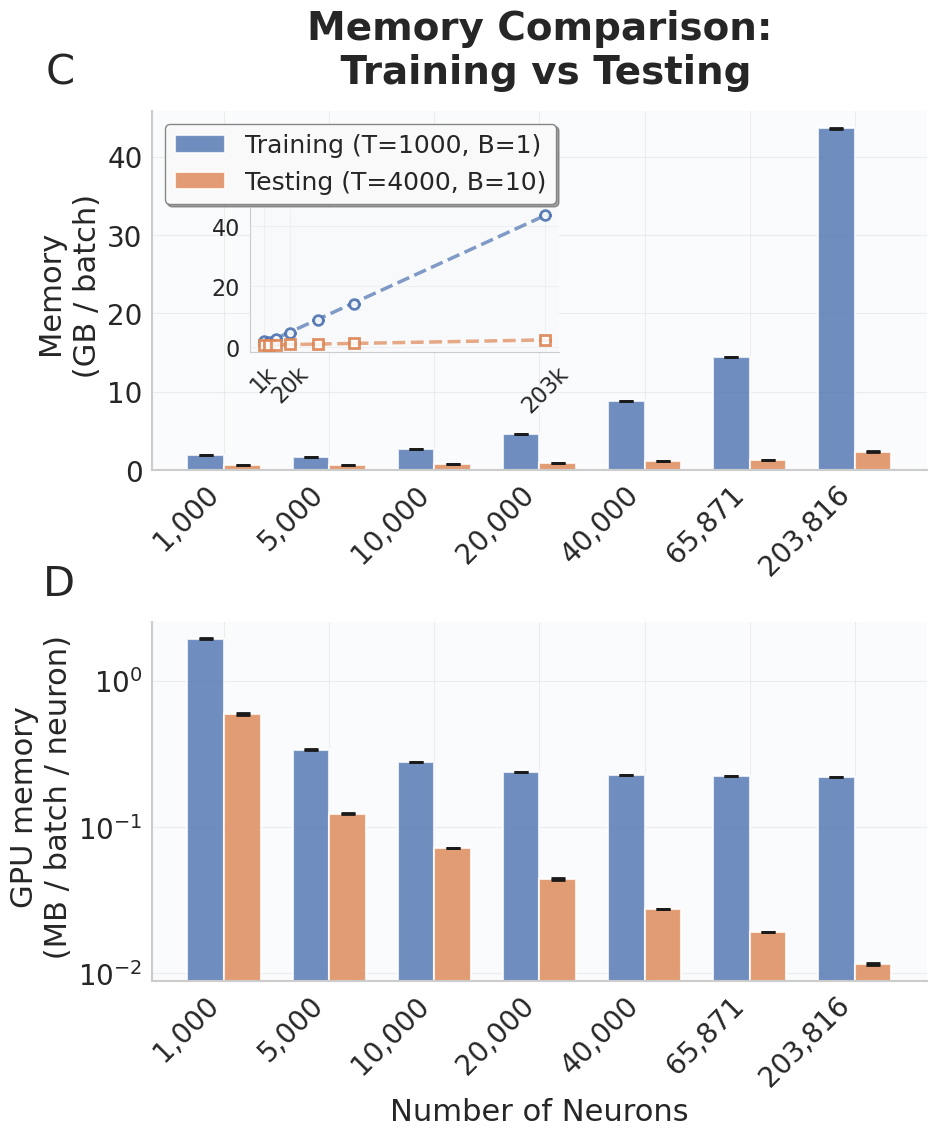

In [7]:
def create_normalized_memory_comparison(train_df, test_df, output_dir=''):
    """
    Create a specialized comparison between train and test data for sequence length 1000,
    with step time normalized by batch size to provide a fair comparison.
    
    Parameters:
    -----------
    train_df : pandas.DataFrame
        DataFrame containing the training data
    test_df : pandas.DataFrame
        DataFrame containing the testing data
    output_dir : str
        Directory to save the generated figures
    """
    # Set publication-ready style
    plt.style.use('default')
    sns.set_style("whitegrid", {"axes.spines.right": False, "axes.spines.top": False})
    sns.set_palette("deep")
    
    # Create output directory if it doesn't exist
    # os.makedirs(output_dir, exist_ok=True)
    # Filter for sequence length 1000 in training data
    train_seq1000 = train_df[train_df['seq_len'] == 1000] if 'seq_len' in train_df.columns else pd.DataFrame()
    train_seq1000 = train_seq1000[train_seq1000['batch_size'] == 1] if 'batch_size' in train_seq1000.columns else pd.DataFrame()

    # Prepare test data (might not have seq_len column if it's constant)
    test_data = test_df.copy()
    # Normalize step times by batch size for fair comparison
    if not train_seq1000.empty:
        train_seq1000['normalized_memory'] = train_seq1000['memory'] / train_seq1000['batch_size']
        train_seq1000['normalized_memory_sem'] = train_seq1000['memory_sem'] / train_seq1000['batch_size']
    if not test_data.empty:
        test_data['normalized_memory'] = test_data['memory'] / test_data['batch_size']
        test_data['normalized_memory_sem'] = test_data['memory_sem'] / test_data['batch_size']

    # Create figure for comparison
    if not train_seq1000.empty and not test_data.empty:
        # Create figure with improved styling
        fig = plt.figure(figsize=(10, 12))
        
        # Define colors using seaborn palette
        colors = sns.color_palette("deep", 2)
        train_color = colors[0]  # Blue
        test_color = colors[1]   # Orange
        
        # Panel 1: Normalized Step Time vs Neuron Count (with inset for line plot)
        ax1 = plt.subplot(2, 1, 1)
        # Get common neuron values
        common_neurons = sorted(set(train_seq1000['neurons'].unique()) & set(test_data['neurons'].unique()))
        # Calculate average normalized step times and SEM for each neuron count
        train_norm_times = []
        test_norm_times = []
        train_norm_sems = []
        test_norm_sems = []
        
        for neuron in common_neurons:
            # Filter data for this neuron count
            train_neurons = train_seq1000[train_seq1000['neurons'] == neuron]
            test_neurons = test_data[test_data['neurons'] == neuron]
            # Calculate mean normalized step time and SEM for each mode
            train_norm_time = train_neurons['normalized_memory'].mean()
            test_norm_time = test_neurons['normalized_memory'].mean()
            train_norm_sem = train_neurons['normalized_memory_sem'].mean() 
            test_norm_sem = test_neurons['normalized_memory_sem'].mean()

            train_norm_times.append(train_norm_time)
            test_norm_times.append(test_norm_time)
            train_norm_sems.append(train_norm_sem)
            test_norm_sems.append(test_norm_sem)
        
        # Plot bar chart comparison with error bars
        x = np.arange(len(common_neurons))
        width = 0.35

        bars1 = ax1.bar(x - width/2, train_norm_times, width, 
                       label='Training (T=1000, B=1)', color=train_color,
                       yerr=train_norm_sems, capsize=5, error_kw={'linewidth': 2, 'capthick': 2},
                       alpha=0.8, edgecolor='white', linewidth=1.5)
        bars2 = ax1.bar(x + width/2, test_norm_times, width, 
                       label='Testing (T=4000, B=10)', color=test_color,
                       yerr=test_norm_sems, capsize=5, error_kw={'linewidth': 2, 'capthick': 2},
                       alpha=0.8, edgecolor='white', linewidth=1.5)

        ax1.set_ylabel('Memory \n (GB / batch)', fontsize=22, fontweight='normal')
        ax1.set_title('Memory Comparison:\n Training vs Testing', 
                     fontweight='bold', fontsize=28, pad=20)
        ax1.set_xticks(x)
        ax1.set_xticklabels([f"{n:,}" for n in common_neurons], rotation=45, 
                           fontsize=20, ha='right')
        ax1.tick_params(axis='y', labelsize=20)
        ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
        
        # Improve legend
        legend = ax1.legend(fontsize=18, loc='upper left', frameon=True, 
                           fancybox=True, shadow=True, framealpha=0.95)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_edgecolor('gray')
        
        # Create inset for line plot - FIXED: provide 4-tuple for bbox_to_anchor
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        ax_inset = inset_axes(ax1, width="40%", height="40%", loc='upper left', 
                             borderpad=7, #bbox_to_anchor=(0.5, 0.5, 0.45, 0.45), 
                             bbox_transform=ax1.transAxes)

        # Plot normalized step time vs neuron count for both modes (line plot) with error bars
        ax_inset.errorbar(common_neurons, train_norm_times, yerr=train_norm_sems,
                         fmt='o', label='Training', color=train_color, 
                         linewidth=3, markersize=7, capsize=4, capthick=2,
                         markerfacecolor='white', markeredgewidth=2, alpha=0.9)
        ax_inset.errorbar(common_neurons, test_norm_times, yerr=test_norm_sems,
                         fmt='s', label='Testing', color=test_color, 
                         linewidth=3, markersize=7, capsize=4, capthick=2,
                         markerfacecolor='white', markeredgewidth=2, alpha=0.9)
        
        # Add linear fits and print fitting parameters
        train_fit = np.polyfit(common_neurons, train_norm_times, 1)
        train_fit_line = np.poly1d(train_fit)
        ax_inset.plot(common_neurons, train_fit_line(common_neurons), '--', 
                     color=train_color, linewidth=2.5, alpha=0.7)
        
        test_fit = np.polyfit(common_neurons, test_norm_times, 1)
        test_fit_line = np.poly1d(test_fit)
        ax_inset.plot(common_neurons, test_fit_line(common_neurons), '--', 
                     color=test_color, linewidth=2.5, alpha=0.7)
        
        # Print fitting parameters
        print(f"Training linear fit: y = {train_fit[0]:.2e}x + {train_fit[1]:.2e}")
        print(f"Testing linear fit: y = {test_fit[0]:.2e}x + {test_fit[1]:.2e}")
        
        ax_inset.tick_params(axis='both', labelsize=16)
        ax_inset.set_xticks(common_neurons[::3])
        ax_inset.set_xticklabels([f"{n//1000}k" for n in common_neurons[::3]], 
                                fontsize=16, rotation=45)
        ax_inset.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax_inset.set_facecolor('#f8f9fa')

        # Panel 2: Efficiency metrics
        ax2 = plt.subplot(2, 1, 2)
        
        # Calculate efficiency metrics (time per neuron) for both modes
        train_time_per_neuron = [t/n for t, n in zip(train_norm_times, common_neurons)]
        test_time_per_neuron = [t/n for t, n in zip(test_norm_times, common_neurons)]
        # Calculate SEM for efficiency metrics
        train_time_per_neuron_sem = [sem/n for sem, n in zip(train_norm_sems, common_neurons)]
        test_time_per_neuron_sem = [sem/n for sem, n in zip(test_norm_sems, common_neurons)]
        
        # Create a grouped bar chart with error bars
        bar_width = 0.35
        x = np.arange(len(common_neurons))
        
        bars3 = ax2.bar(x - bar_width/2, 
                   [t * 1024 for t in train_time_per_neuron], # convert GB to MB
                   bar_width, 
                   label='Training', 
                   color=train_color,
                   yerr=[sem * 1024 for sem in train_time_per_neuron_sem], # convert GB to MB
                   capsize=5, error_kw={'linewidth': 2, 'capthick': 2},
                   alpha=0.8, edgecolor='white', linewidth=1.5)
        
        bars4 = ax2.bar(x + bar_width/2, 
                   [t * 1024 for t in test_time_per_neuron], # convert GB to MB
                   bar_width, 
                   label='Testing', 
                   color=test_color,
                   yerr=[sem * 1024 for sem in test_time_per_neuron_sem], # convert GB to MB
                   capsize=5, error_kw={'linewidth': 2, 'capthick': 2},
                   alpha=0.8, edgecolor='white', linewidth=1.5)
        
        # Set log scale for y-axis
        ax2.set_yscale('log')
        ax2.set_xlabel('Number of Neurons', fontsize=22, fontweight='normal')
        ax2.set_ylabel('GPU memory \n (MB / batch / neuron)', fontsize=22, fontweight='normal')
        ax2.set_xticks(x)
        ax2.set_xticklabels([f"{n:,}" for n in common_neurons], rotation=45, 
                           fontsize=20, ha='right')
        ax2.tick_params(axis='y', labelsize=20)
        ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
        
        # # Improve legend for second panel
        # legend2 = ax2.legend(fontsize=18, loc='upper left', frameon=True, 
        #                     fancybox=True, shadow=True, framealpha=0.95)
        # legend2.get_frame().set_facecolor('white')
        # legend2.get_frame().set_edgecolor('gray')
        
        # Add subtle background colors to distinguish panels
        ax1.set_facecolor('#fafbfc')
        ax2.set_facecolor('#fafbfc')
        
        # Improve spacing and layout
        plt.tight_layout(pad=3.0)
        
        # Add panel labels
        ax1.text(-0.1, 1.05, 'C', transform=ax1.transAxes, fontsize=30, 
                fontweight='normal', va='bottom', ha='right')
        ax2.text(-0.1, 1.05, 'D', transform=ax2.transAxes, fontsize=30, 
                fontweight='normal', va='bottom', ha='right')
        
        # Remove top and right spines for cleaner look
        for ax in [ax1, ax2]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_linewidth(1.5)
            ax.spines['bottom'].set_linewidth(1.5)
        
        plt.show()
        
create_normalized_memory_comparison(train_df, test_df, output_dir='')

 Initial memory overhead = 0.637


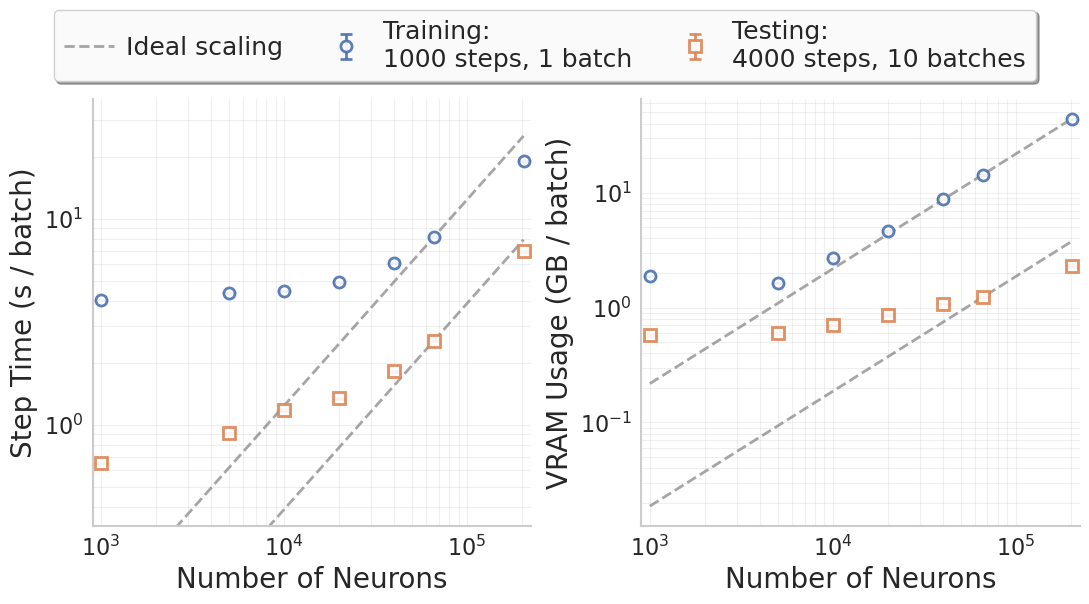

In [10]:
def create_loglog_performance_comparison_fit(train_df, test_df, output_dir=''):
    """
    Create a figure with log-log plots comparing training and testing performance.
    Top subplot: Step time (s/batch) vs number of neurons
    Bottom subplot: VRAM (GB/batch) vs number of neurons

    Parameters:
    -----------
    train_df : pandas.DataFrame
        DataFrame containing the training data
    test_df : pandas.DataFrame
        DataFrame containing the testing data
    output_dir : str
        Directory to save the generated figures
    """
    # Set publication-ready style
    plt.style.use('default')
    sns.set_style("whitegrid", {"axes.spines.right": False, "axes.spines.top": False})
    sns.set_palette("deep")

    # Filter for sequence length 1000 and batch size 1 in training data
    train_seq1000 = train_df[train_df['seq_len'] == 1000] if 'seq_len' in train_df.columns else pd.DataFrame()
    train_seq1000 = train_seq1000[train_seq1000['batch_size'] == 1] if 'batch_size' in train_seq1000.columns else pd.DataFrame()

    # Prepare test data
    test_data = test_df.copy()

    # Normalize by batch size for fair comparison
    if not train_seq1000.empty:
        train_seq1000 = train_seq1000.copy()
        train_seq1000['normalized_step_time'] = train_seq1000['step_time'] / train_seq1000['batch_size']
        train_seq1000['normalized_step_time_sem'] = train_seq1000['step_time_sem'] / train_seq1000['batch_size']
        train_seq1000['normalized_memory'] = train_seq1000['memory'] / train_seq1000['batch_size']
        train_seq1000['normalized_memory_sem'] = train_seq1000['memory_sem'] / train_seq1000['batch_size']
    if not test_data.empty:
        test_data['normalized_step_time'] = test_data['step_time'] / test_data['batch_size']
        test_data['normalized_step_time_sem'] = test_data['step_time_sem'] / test_data['batch_size']
        test_data['normalized_memory'] = test_data['memory'] / test_data['batch_size']
        test_data['normalized_memory_sem'] = test_data['memory_sem'] / test_data['batch_size']

    if not train_seq1000.empty and not test_data.empty:
        # Create figure with shared x-axis
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6), sharex=True, sharey=False)

        # Define colors
        colors = sns.color_palette("deep", 2)
        train_color = colors[0]  # Blue
        test_color = colors[1]   # Orange

        # Get common neuron values
        common_neurons = sorted(set(train_seq1000['neurons'].unique()) & set(test_data['neurons'].unique()))

        # Calculate average values for each neuron count
        train_step_times, test_step_times = [], []
        train_step_sems, test_step_sems = [], []
        train_memories, test_memories = [], []
        train_mem_sems, test_mem_sems = [], []

        for neuron in common_neurons:
            train_neurons = train_seq1000[train_seq1000['neurons'] == neuron]
            test_neurons = test_data[test_data['neurons'] == neuron]

            train_step_times.append(train_neurons['normalized_step_time'].mean())
            test_step_times.append(test_neurons['normalized_step_time'].mean())
            train_step_sems.append(train_neurons['normalized_step_time_sem'].mean())
            test_step_sems.append(test_neurons['normalized_step_time_sem'].mean())

            train_memories.append(train_neurons['normalized_memory'].mean())
            test_memories.append(test_neurons['normalized_memory'].mean())
            train_mem_sems.append(train_neurons['normalized_memory_sem'].mean())
            test_mem_sems.append(test_neurons['normalized_memory_sem'].mean())

        # Convert to numpy arrays
        common_neurons = np.array(common_neurons)
        train_step_times = np.array(train_step_times)
        test_step_times = np.array(test_step_times)
        train_step_sems = np.array(train_step_sems)
        test_step_sems = np.array(test_step_sems)
        train_memories = np.array(train_memories)
        test_memories = np.array(test_memories)
        train_mem_sems = np.array(train_mem_sems)
        test_mem_sems = np.array(test_mem_sems)

        # =====================================================================
        # Panel a: Step Time (s/batch) vs Number of Neurons (log-log)
        # =====================================================================

        ax1.errorbar(common_neurons, train_step_times, yerr=train_step_sems,
                    fmt='o', label='Training:\n1000 steps, 1 batch', color=train_color,
                    linewidth=2, markersize=8, capsize=4, capthick=2,
                    markerfacecolor='white', markeredgewidth=2, alpha=0.9)

        ax1.errorbar(common_neurons, test_step_times, yerr=test_step_sems,
                    fmt='s', label='Testing:\n4000 steps, 10 batches', color=test_color,
                    linewidth=2, markersize=8, capsize=4, capthick=2,
                    markerfacecolor='white', markeredgewidth=2, alpha=0.9)

        # Add slope-1 reference line anchored at the smallest network size
        anchor_neuron = common_neurons[5]
        anchor_time = train_step_times[5]
        slope1_time = anchor_time * (common_neurons / anchor_neuron)
        ax1.plot(common_neurons, slope1_time, '--', color='gray',
                 linewidth=2, alpha=0.7, label='Ideal scaling') #label='_nolegend_')

        anchor_time = test_step_times[5]
        slope1_time = anchor_time * (common_neurons / anchor_neuron)
        ax1.plot(common_neurons, slope1_time, '--', color='gray',
                 linewidth=2, alpha=0.7, label='_nolegend_') #label='_nolegend_')

        # Set log-log scale
        ax1.set_xscale('log')
        ax1.set_yscale('log')

        # Set x-axis limits
        ax1.set_xlim([common_neurons.min() * 0.9, common_neurons.max() * 1.1])
        ax1.set_ylim([min(train_step_times.min(), test_step_times.min()) * 0.5, 
                      max(train_step_times.max(), test_step_times.max()) * 2])
        ax1.set_xlabel('Number of Neurons', fontsize=20, fontweight='normal')
        ax1.set_ylabel('Step Time (s / batch)', fontsize=20, fontweight='normal')
        ax1.tick_params(axis='both', labelsize=16)
        ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.8, which='both')

        # =====================================================================
        # Panel b: VRAM (GB/batch) vs Number of Neurons (log-log)
        # =====================================================================

        # Get the initial overhead
        fit_params, cov_matrix = np.polyfit(common_neurons, train_memories, 1, cov=True)
        slope, initial_train_overhead = fit_params
        fit_params, cov_matrix = np.polyfit(common_neurons, test_memories, 1, cov=True)
        slope, initial_test_overhead = fit_params
        print(f" Initial memory overhead = {initial_test_overhead :.3f}")

        ax2.errorbar(common_neurons, train_memories, yerr=train_mem_sems,
                    fmt='o', label='_nolegend_', color=train_color,
                    linewidth=2, markersize=8, capsize=4, capthick=2,
                    markerfacecolor='white', markeredgewidth=2, alpha=0.9)
        ax2.errorbar(common_neurons, test_memories, yerr=test_mem_sems,
                    fmt='s', label='_nolegend_', color=test_color,
                    linewidth=2, markersize=8, capsize=4, capthick=2,
                    markerfacecolor='white', markeredgewidth=2, alpha=0.9)

        # Add slope-1 reference line anchored at the smallest network size
        anchor_mem = train_memories[5]
        slope1_mem = anchor_mem * (common_neurons / anchor_neuron)
        ax2.plot(common_neurons, slope1_mem, '--', color='gray',
                 linewidth=2, alpha=0.7, label='_nolegend_')

        anchor_mem = test_memories[5]
        slope1_mem = anchor_mem * (common_neurons / anchor_neuron)
        ax2.plot(common_neurons, slope1_mem, '--', color='gray',
                 linewidth=2, alpha=0.7, label='_nolegend_')

        # Set log scale for y-axis (x-axis is shared)
        ax2.set_yscale('log')
        ax2.set_xscale('log')        
        ax2.set_xlabel('Number of Neurons', fontsize=20, fontweight='normal')
        ax2.set_ylabel('VRAM Usage (GB / batch)', fontsize=20, fontweight='normal')
        ax2.tick_params(axis='both', labelsize=16)
        ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.8, which='both')

        # Remove top and right spines
        for ax in [ax1, ax2]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_linewidth(1.5)
            ax.spines['bottom'].set_linewidth(1.5)

        # Add figure legend including slope-1 reference
        handles, labels = ax1.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02),
                  fontsize=18, frameon=True, fancybox=True, shadow=True, 
                  framealpha=0.95, ncol=3, columnspacing=1.5, handletextpad=0.5)

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)  # Make room for the legend

        plt.savefig(f'figures/loglog_performance_comparison_fit.png', dpi=300, transparent=True)
        plt.show()

create_loglog_performance_comparison_fit(train_df, test_df, output_dir='Paper_figures')

In [8]:
train_df['mean_rate']

0     0.0037
1     0.0036
2     0.0036
3     0.0036
4     0.0036
10    0.0037
12    0.0030
Name: mean_rate, dtype: float64

In [9]:
train_df.drop(['neurons'], axis=1, inplace=True)
train_df = train_df.rename(columns={'n_edges':'neurons'})

test_df.drop(['neurons'], axis=1, inplace=True)
test_df = test_df.rename(columns={'n_edges':'neurons'})
# remove neurons column
# test_data = test_data.rename(columns={'n_edges':'neurons'})
train_df

/tmp/ipykernel_1141559/1854287819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(['neurons'], axis=1, inplace=True)
/tmp/ipykernel_1141559/1854287819.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(['neurons'], axis=1, inplace=True)


,sim_name,neurons,batch_size,seq_len,mean_rate,sem_rate,step_time,step_time_sem,memory,memory_sem,mode
0,b_on0m,544263,1,1000,0.0037,0.0,4.0264,0.0054,1.8926,0.0072,train
1,b_y7bf,3074601,1,1000,0.0036,0.0,4.3592,0.0052,1.6511,0.0026,train
2,b_ubco,6645432,1,1000,0.0036,0.0,4.4366,0.0053,2.7256,0.0015,train
3,b_aeym,14807994,1,1000,0.0036,0.0,4.9276,0.0065,4.6116,0.0016,train
4,b_gh6y,31863080,1,1000,0.0036,0.0,6.0974,0.0061,8.8211,0.0022,train
10,b_k2zc,54378241,1,1000,0.0037,0.0,8.1367,0.0065,14.3594,0.0033,train
12,b_g0i6,179735332,1,1000,0.0030,0.0,19.0208,0.0104,43.6048,0.0264,train


/tmp/ipykernel_1141559/60848416.py:87: RuntimeWarning: overflow encountered in power
  return t0 + a * N**beta


STEP TIME POWER LAW FIT: t(N) = t0 + a*N^β
t0 (baseline) = 4.0405 ± 0.0036 s
a (coefficient) = 7.9912e-06 ± 1.49e-07
β (exponent) = 1.1817 ± 0.0015

MEMORY POWER LAW FIT: M(N) = M0 + a*N^β
M0 (baseline) = 0.8497 ± 0.0025 GB
a (coefficient) = 1.1614e-04 ± 6.17e-07
β (exponent) = 1.0506 ± 0.0005



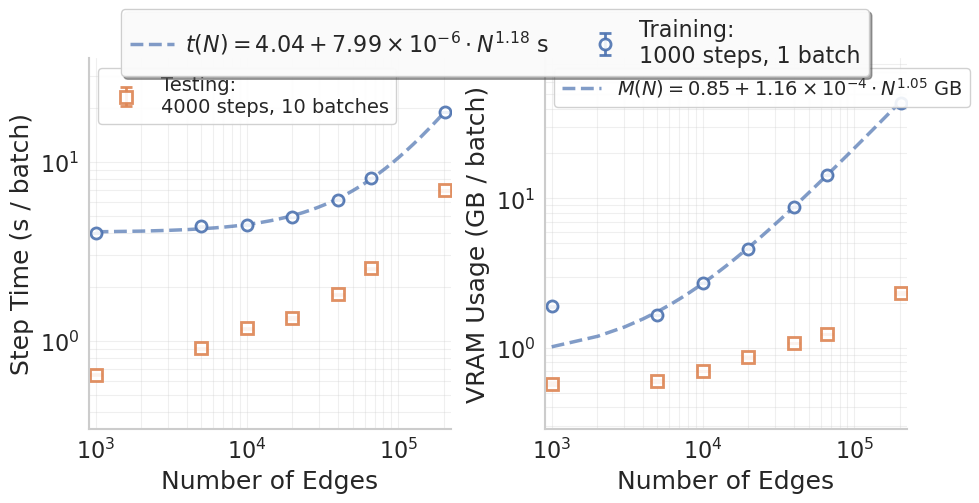

In [29]:
from scipy.optimize import curve_fit

def create_powerlaw_fit_figure(train_df, test_df, output_dir=''):
    """
    Create a figure with power law fits of the form t(N) = t0 + a*N^beta
    for both step time and memory usage.
    
    Parameters:
    -----------
    train_df : pandas.DataFrame
        DataFrame containing the training data
    test_df : pandas.DataFrame
        DataFrame containing the testing data
    output_dir : str
        Directory to save the generated figures
    """
    # Set publication-ready style
    plt.style.use('default')
    sns.set_style("whitegrid", {"axes.spines.right": False, "axes.spines.top": False})
    sns.set_palette("deep")
    
    # Filter for sequence length 1000 and batch size 1 in training data
    train_seq1000 = train_df[train_df['seq_len'] == 1000] if 'seq_len' in train_df.columns else pd.DataFrame()
    train_seq1000 = train_seq1000[train_seq1000['batch_size'] == 1] if 'batch_size' in train_seq1000.columns else pd.DataFrame()

    # Prepare test data
    test_data = test_df.copy()
    
    # Normalize by batch size for fair comparison
    if not train_seq1000.empty:
        train_seq1000 = train_seq1000.copy()
        train_seq1000['normalized_step_time'] = train_seq1000['step_time'] / train_seq1000['batch_size']
        train_seq1000['normalized_step_time_sem'] = train_seq1000['step_time_sem'] / train_seq1000['batch_size']
        train_seq1000['normalized_memory'] = train_seq1000['memory'] / train_seq1000['batch_size']
        train_seq1000['normalized_memory_sem'] = train_seq1000['memory_sem'] / train_seq1000['batch_size']
    if not test_data.empty:
        test_data['normalized_step_time'] = test_data['step_time'] / test_data['batch_size']
        test_data['normalized_step_time_sem'] = test_data['step_time_sem'] / test_data['batch_size']
        test_data['normalized_memory'] = test_data['memory'] / test_data['batch_size']
        test_data['normalized_memory_sem'] = test_data['memory_sem'] / test_data['batch_size']

    if not train_seq1000.empty and not test_data.empty:
        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=False)
        
        # Define colors
        colors = sns.color_palette("deep", 2)
        train_color = colors[0]  # Blue
        test_color = colors[1]   # Orange
        
        # Get common neuron values
        common_neurons = sorted(set(train_seq1000['neurons'].unique()) & set(test_data['neurons'].unique()))
        
        # Calculate average values for each neuron count
        train_step_times, test_step_times = [], []
        train_step_sems, test_step_sems = [], []
        train_memories, test_memories = [], []
        train_mem_sems, test_mem_sems = [], []
        
        for neuron in common_neurons:
            train_neurons = train_seq1000[train_seq1000['neurons'] == neuron]
            test_neurons = test_data[test_data['neurons'] == neuron]
            
            train_step_times.append(train_neurons['normalized_step_time'].mean())
            test_step_times.append(test_neurons['normalized_step_time'].mean())
            train_step_sems.append(train_neurons['normalized_step_time_sem'].mean())
            test_step_sems.append(test_neurons['normalized_step_time_sem'].mean())
            
            train_memories.append(train_neurons['normalized_memory'].mean())
            test_memories.append(test_neurons['normalized_memory'].mean())
            train_mem_sems.append(train_neurons['normalized_memory_sem'].mean())
            test_mem_sems.append(test_neurons['normalized_memory_sem'].mean())
        
        # Convert to numpy arrays
        common_neurons = np.array(common_neurons)
        train_step_times = np.array(train_step_times)
        test_step_times = np.array(test_step_times)
        train_step_sems = np.array(train_step_sems)
        test_step_sems = np.array(test_step_sems)
        train_memories = np.array(train_memories)
        test_memories = np.array(test_memories)
        train_mem_sems = np.array(train_mem_sems)
        test_mem_sems = np.array(test_mem_sems)
        
        # Define power law function: t(N) = t0 + a * N^beta
        def power_law(N, t0, a, beta):
            return t0 + a * N**beta
        
        # =====================================================================
        # Panel a: Step Time vs Number of Neurons with Power Law Fit
        # =====================================================================
        
        # Filter for fitting (neurons >= 10k)
        mask_fit = common_neurons >= 0
        
        # Plot data
        ax1.errorbar(common_neurons, train_step_times, yerr=train_step_sems,
                    fmt='o', label='Training:\n1000 steps, 1 batch', color=train_color,
                    linewidth=2, markersize=8, capsize=4, capthick=2,
                    markerfacecolor='white', markeredgewidth=2, alpha=0.9)

        ax1.errorbar(common_neurons, test_step_times, yerr=test_step_sems,
                    fmt='s', label='Testing:\n4000 steps, 10 batches', color=test_color,
                    linewidth=2, markersize=8, capsize=4, capthick=2,
                    markerfacecolor='white', markeredgewidth=2, alpha=0.9)
        
        # Fit power law to training data
        if np.sum(mask_fit) > 3:  # Need at least 3 points for 3 parameters
            try:
                # Initial guess for parameters
                p0 = [3.5, 1e-9, 1.]  # [t0, a, beta]
                
                # Perform curve fitting
                popt, pcov = curve_fit(power_law, common_neurons[mask_fit], train_step_times[mask_fit], 
                                      p0=p0, sigma=train_step_sems[mask_fit], absolute_sigma=True)
                
                # Extract parameters and errors
                t0, a, beta = popt
                perr = np.sqrt(np.diag(pcov))
                t0_err, a_err, beta_err = perr
                
                # Generate fit line
                N_fit = np.linspace(common_neurons.min(), common_neurons.max(), 200)
                fit_line = power_law(N_fit, t0, a, beta)
                
                # Format the fit equation with proper units and scientific notation
                # Determine the appropriate order of magnitude for 'a'
                a_order = np.floor(np.log10(abs(a)))
                a_mantissa = a / (10**a_order)
                
                fit_label = (f'$t(N) = {t0:.2f} + {a_mantissa:.2f} \\times 10^{{{int(a_order)}}} '
                           f'\\cdot N^{{{beta:.2f}}}$ s')
                ax1.plot(N_fit, fit_line, '--', color=train_color, 
                        linewidth=2.5, alpha=0.7, label=fit_label)
                
                # Print results
                print("=" * 60)
                print("STEP TIME POWER LAW FIT: t(N) = t0 + a*N^β")
                print("=" * 60)
                print(f"t0 (baseline) = {t0:.4f} ± {t0_err:.4f} s")
                print(f"a (coefficient) = {a:.4e} ± {a_err:.2e}")
                print(f"β (exponent) = {beta:.4f} ± {beta_err:.4f}")
                print()
                
            except Exception as e:
                print(f"Warning: Power law fit failed for step time: {e}")
        
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlim([common_neurons.min() * 0.9, common_neurons.max() * 1.1])
        ax1.set_ylim([min(train_step_times.min(), test_step_times.min()) * 0.5, 
                      max(train_step_times.max(), test_step_times.max()) * 2])
        ax1.set_xlabel('Number of Edges', fontsize=18, fontweight='normal')
        ax1.set_ylabel('Step Time (s / batch)', fontsize=18, fontweight='normal')
        ax1.tick_params(axis='both', labelsize=16)
        ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.8, which='both')
        
        # =====================================================================
        # Panel b: Memory vs Number of Neurons with Power Law Fit
        # =====================================================================
        
        # Plot data
        ax2.errorbar(common_neurons, train_memories, yerr=train_mem_sems,
                    fmt='o', label='_nolegend_', color=train_color,
                    linewidth=2, markersize=8, capsize=4, capthick=2,
                    markerfacecolor='white', markeredgewidth=2, alpha=0.9)
        ax2.errorbar(common_neurons, test_memories, yerr=test_mem_sems,
                    fmt='s', label='_nolegend_', color=test_color,
                    linewidth=2, markersize=8, capsize=4, capthick=2,
                    markerfacecolor='white', markeredgewidth=2, alpha=0.9)
        
        # Fit power law to training data
        if np.sum(mask_fit) > 3:
            try:
                # Initial guess for parameters
                p0 = [1.0, 1e-8, 1.0]  # [t0, a, beta]
                
                # Perform curve fitting
                popt_mem, pcov_mem = curve_fit(power_law, common_neurons[mask_fit], train_memories[mask_fit], 
                                               p0=p0, sigma=train_mem_sems[mask_fit], absolute_sigma=True)
                
                # Extract parameters and errors
                t0_mem, a_mem, beta_mem = popt_mem
                perr_mem = np.sqrt(np.diag(pcov_mem))
                t0_mem_err, a_mem_err, beta_mem_err = perr_mem
                
                # Generate fit line
                fit_line_mem = power_law(N_fit, t0_mem, a_mem, beta_mem)
                
                # Format the fit equation with proper units and scientific notation
                a_mem_order = np.floor(np.log10(abs(a_mem)))
                a_mem_mantissa = a_mem / (10**a_mem_order)
                
                fit_label_mem = (f'$M(N) = {t0_mem:.2f} + {a_mem_mantissa:.2f} \\times 10^{{{int(a_mem_order)}}} '
                               f'\\cdot N^{{{beta_mem:.2f}}}$ GB')
                ax2.plot(N_fit, fit_line_mem, '--', color=train_color, 
                        linewidth=2.5, alpha=0.7, label=fit_label_mem)
                
                # Print results
                print("=" * 60)
                print("MEMORY POWER LAW FIT: M(N) = M0 + a*N^β")
                print("=" * 60)
                print(f"M0 (baseline) = {t0_mem:.4f} ± {t0_mem_err:.4f} GB")
                print(f"a (coefficient) = {a_mem:.4e} ± {a_mem_err:.2e}")
                print(f"β (exponent) = {beta_mem:.4f} ± {beta_mem_err:.4f}")
                print()
                
            except Exception as e:
                print(f"Warning: Power law fit failed for memory: {e}")
        
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.set_xlim([common_neurons.min() * 0.9, common_neurons.max() * 1.1])
        ax2.set_ylim([min(train_memories.min(), test_memories.min()) * 0.5, 
                      max(train_memories.max(), test_memories.max()) * 2])
        ax2.set_xlabel('Number of Edges', fontsize=18, fontweight='normal')
        ax2.set_ylabel('VRAM Usage (GB / batch)', fontsize=18, fontweight='normal')
        ax2.tick_params(axis='both', labelsize=16)
        ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.8, which='both')
        
        # Remove top and right spines
        for ax in [ax1, ax2]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_linewidth(1.5)
            ax.spines['bottom'].set_linewidth(1.5)
        
        # Add figure legend
        handles, labels = ax1.get_legend_handles_labels()
        # Shared legend: Training and Testing (first 2 items)
        fig.legend(handles[:2], labels[:2], loc='upper center', bbox_to_anchor=(0.5, 1.02),
                  fontsize=16, frameon=True, fancybox=True, shadow=True, 
                  framealpha=0.95, ncol=2, columnspacing=1.5, handletextpad=0.5)
        
        # Add panel-specific legends for the power law fit line
        if len(handles) > 2:
            ax1.legend([handles[2]], [labels[2]], loc='upper left', fontsize=14,
                      frameon=True, fancybox=True, framealpha=0.9)
            
        handles2, labels2 = ax2.get_legend_handles_labels()
        if len(handles2) > 0:
            ax2.legend([handles2[0]], [labels2[0]], loc='upper left', fontsize=14,
                      frameon=True, fancybox=True, framealpha=0.9)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.90)
        plt.show()

# Run the new power law fitting
create_powerlaw_fit_figure(train_df, test_df, output_dir='')

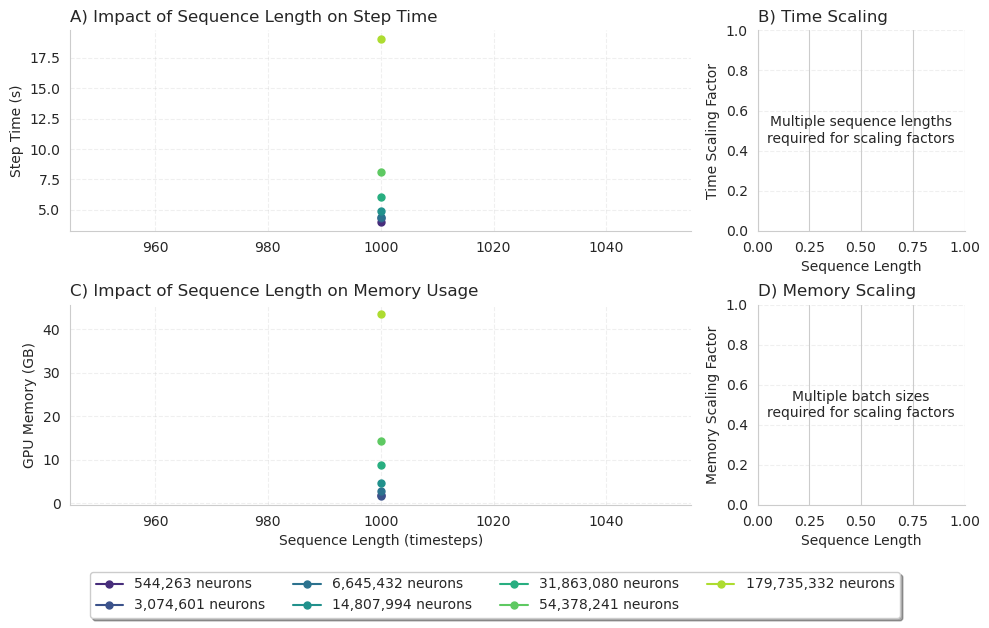

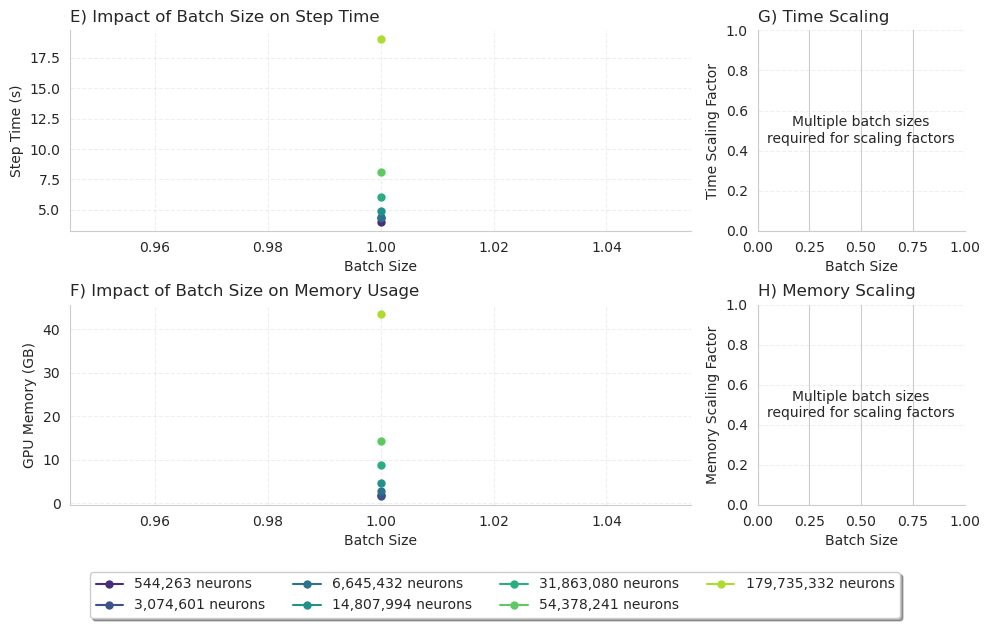

In [11]:
# import gridspec from matplotlib
from matplotlib.gridspec import GridSpec

def plot_performance_figures(df, output_dir='figures/performance'):
    """
    Create publication-quality figures visualizing the relationship between
    model parameters and performance metrics.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the performance data
    output_dir : str
        Directory to save the generated figures
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Set a cohesive color palette with enough colors for all neuron counts and sequence lengths
    palette = sns.color_palette("viridis", max(len(df['neurons'].unique()), len(df['seq_len'].unique())))
    
    # =========================================================================
    # FIGURE 1: Sequence Length Impact
    # =========================================================================
    
    fig = plt.figure(figsize=(10, 6))
    gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1], width_ratios=[3, 1])
    
    # Panel A: Step Time vs Sequence Length
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Prepare the data (average over samples)
    seq_len_data = df[df['batch_size'] == 1].groupby(['seq_len', 'neurons']).agg(
        mean_step_time=('step_time', 'mean'),
        sem_step_time=('step_time', 'sem')
    ).reset_index()
    
    # Create line plot with error bands
    for i, neurons in enumerate(sorted(df['neurons'].unique())):
        subset = seq_len_data[seq_len_data['neurons'] == neurons]
        # Multiply seq_len by 2 to account for two phases per training step
        ax1.plot(subset['seq_len'], subset['mean_step_time'], 
                marker='o', markersize=5, label=f"{neurons:,} neurons", 
                color=palette[i])
        ax1.fill_between(subset['seq_len'], 
                        subset['mean_step_time'] - subset['sem_step_time'],
                        subset['mean_step_time'] + subset['sem_step_time'],
                        alpha=0.2, color=palette[i])
    
    # Set x-ticks to only show values present in the data
    # ax1.set_xticks(sorted(df['seq_len'].unique()))
    
    # ax1.set_xlabel('Sequence Length (timesteps)')
    ax1.set_ylabel('Step Time (s)')
    ax1.grid(alpha=0.3, linestyle='--')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_title('A) Impact of Sequence Length on Step Time', fontweight='normal', loc='left')
    
    # Panel B: Memory vs Sequence Length
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    
    # Prepare the data
    seq_len_mem_data = df[df['batch_size'] == 1].groupby(['seq_len', 'neurons']).agg(
        mean_memory=('memory', 'mean'),
        sem_memory=('memory', 'sem')
    ).reset_index()
    
    # Create line plot with error bands
    for i, neurons in enumerate(sorted(df['neurons'].unique())):
        subset = seq_len_mem_data[seq_len_mem_data['neurons'] == neurons]
        ax2.plot(subset['seq_len'], subset['mean_memory'], 
                marker='o', markersize=5, label=f"{neurons:,} neurons", 
                color=palette[i])
        ax2.fill_between(subset['seq_len'], 
                        subset['mean_memory'] - subset['sem_memory'],
                        subset['mean_memory'] + subset['sem_memory'],
                        alpha=0.2, color=palette[i])
    
    ax2.set_xlabel('Sequence Length (timesteps)')
    ax2.set_ylabel('GPU Memory (GB)')
    ax2.grid(alpha=0.3, linestyle='--')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_title('C) Impact of Sequence Length on Memory Usage', fontweight='normal', loc='left')
    
    # Panel C: Bar chart showing time scaling factor (normalized to smallest seq_len)
    ax3 = fig.add_subplot(gs[0, 1])
    
    # Check if we have multiple sequence lengths to calculate scaling factors
    seq_len_values = sorted(df['seq_len'].unique())
    if len(seq_len_values) > 1:
        # Calculate scaling factors for sequence length 
        scaling_data = []
        baseline_seq_len = min(df['seq_len'].unique())
        
        # Compute scaling factors (average across neuron counts)
        for neurons in sorted(df['neurons'].unique()):
            neuron_data = df[(df['batch_size'] == 1) & (df['neurons'] == neurons)]
            baseline_data = neuron_data[neuron_data['seq_len'] == baseline_seq_len]
            
            # Check if baseline data exists
            if not baseline_data.empty:
                baseline_time = baseline_data['step_time'].mean()
                
                for seq_len in sorted(df['seq_len'].unique()):
                    if seq_len != baseline_seq_len:
                        seq_len_data = neuron_data[neuron_data['seq_len'] == seq_len]
                        if not seq_len_data.empty:
                            current_time = seq_len_data['step_time'].mean()
                            scaling_factor = current_time / baseline_time
                            scaling_data.append({
                                'neurons': neurons,
                                'seq_len': seq_len,
                                'scaling_factor': scaling_factor
                            })
        
        # Create DataFrame and check if we have data
        scaling_df = pd.DataFrame(scaling_data)
        
        if not scaling_df.empty and 'seq_len' in scaling_df.columns:
            # Compute average scaling factors across neuron counts
            avg_scaling = scaling_df.groupby('seq_len')['scaling_factor'].mean().reset_index()
            sem_scaling = scaling_df.groupby('seq_len')['scaling_factor'].sem().reset_index()
            
            # Plot scaling factors as bar chart
            bars = ax3.bar(avg_scaling['seq_len'].astype(str), avg_scaling['scaling_factor'], 
                          yerr=sem_scaling['scaling_factor'], capsize=4,
                          color=palette[1], edgecolor='black', linewidth=1)
            
            # Annoate bars with values
            for bar in bars:
                height = bar.get_height()
                ax3.annotate(f'{height:.1f}x',
                            xy=(bar.get_x() + bar.get_width()/2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom',
                            fontsize=10)
        else:
            # Not enough data for scaling factor visualization
            ax3.text(0.5, 0.5, "Insufficient data\nfor scaling factors",
                    ha='center', va='center', transform=ax3.transAxes)
    else:
        # Not enough sequence length values
        ax3.text(0.5, 0.5, "Multiple sequence lengths\nrequired for scaling factors",
                ha='center', va='center', transform=ax3.transAxes)
    
    ax3.set_xlabel('Sequence Length')
    ax3.set_ylabel('Time Scaling Factor')
    ax3.set_title('B) Time Scaling', fontweight='normal', loc='left')
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    
    # Panel D: Memory scaling factors
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Check if we have data to calculate batch memory scaling factors
    seq_len_values = sorted(df['seq_len'].unique())

    if len(seq_len_values) > 1:
        try:
            # Calculate scaling factors for batch size memory impact
            batch_mem_scaling_data = []
            baseline_seq_len = min(df['seq_len'].unique())
            
            for neurons in sorted(df['neurons'].unique()):
                neuron_data = df[(df['batch_size'] == 1) & (df['neurons'] == neurons)]
                if not neuron_data.empty and baseline_seq_len in neuron_data['seq_len'].values:
                    baseline_mem = neuron_data[neuron_data['seq_len'] == baseline_seq_len]['memory'].mean()

                    for batch_size in sorted(df['seq_len'].unique()):
                        if batch_size != baseline_seq_len and batch_size in neuron_data['seq_len'].values:
                            current_mem = neuron_data[neuron_data['seq_len'] == batch_size]['memory'].mean()
                            scaling_factor = current_mem / baseline_mem
                            batch_mem_scaling_data.append({
                                'neurons': neurons,
                                'seq_len': batch_size,
                                'scaling_factor': scaling_factor
                            })
            
            # If we have scaling data, create DataFrame and generate visualization
            if batch_mem_scaling_data:
                batch_mem_scaling_df = pd.DataFrame(batch_mem_scaling_data)
                
                # Compute average scaling factors
                avg_batch_mem_scaling = batch_mem_scaling_df.groupby('seq_len')['scaling_factor'].mean().reset_index()
                sem_batch_mem_scaling = batch_mem_scaling_df.groupby('seq_len')['scaling_factor'].sem().reset_index()
                
                # Plot memory scaling factors
                bars = ax4.bar(avg_batch_mem_scaling['seq_len'].astype(str), 
                              avg_batch_mem_scaling['scaling_factor'],
                              yerr=sem_batch_mem_scaling['scaling_factor'], 
                              capsize=4, color=palette[2], 
                              edgecolor='black', linewidth=1)
                
                # Annotate bars with values
                for bar in bars:
                    height = bar.get_height()
                    ax4.annotate(f'{height:.1f}x',
                                xy=(bar.get_x() + bar.get_width()/2, height),
                                xytext=(0, 3),  
                                textcoords="offset points",
                                ha='center', va='bottom',
                                fontsize=10)
            else:
                # Not enough data for batch scaling factors
                ax4.text(0.5, 0.5, "Insufficient data\nfor memory scaling factors",
                        ha='center', va='center', transform=ax4.transAxes)
        except Exception as e:
            # Handle any errors during calculation
            print(f"Warning: Could not calculate batch memory scaling factors: {e}")
            ax4.text(0.5, 0.5, "Error calculating\nmemory scaling factors",
                    ha='center', va='center', transform=ax4.transAxes)
    else:
        # Not enough batch size values
        ax4.text(0.5, 0.5, "Multiple batch sizes\nrequired for scaling factors",
                ha='center', va='center', transform=ax4.transAxes)
    
    ax4.set_xlabel('Sequence Length')
    ax4.set_ylabel('Memory Scaling Factor')
    ax4.set_title('D) Memory Scaling', fontweight='normal', loc='left')
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    
    # Add legend for the whole figure
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),
              fancybox=True, shadow=True, ncol=4)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for the legend
    # plt.savefig(os.path.join(output_dir, 'sequence_length_impact.png'), dpi=300)
    # plt.savefig(os.path.join(output_dir, 'sequence_length_impact.pdf'))
    # plt.close()
    plt.show()
    
    # =========================================================================
    # FIGURE 2: Batch Size Impact
    # =========================================================================
    
    fig = plt.figure(figsize=(10, 6))
    gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1], width_ratios=[3, 1])
    
    # Panel A: Step Time vs Batch Size
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Check if we have multiple sequence lengths
    if len(seq_len_values) > 0:
        # Use the middle sequence length for better visualization
        try:
            middle_seq_len = sorted(df['seq_len'].unique())[1]  # e.g., 500
        except IndexError:
            # If there's only one sequence length, use that
            middle_seq_len = sorted(df['seq_len'].unique())[0]
            
        # Prepare the data
        batch_data = df[df['seq_len'] == middle_seq_len].groupby(['batch_size', 'neurons']).agg(
            mean_step_time=('step_time', 'mean'),
            sem_step_time=('step_time', 'sem')
        ).reset_index()
        
        # Create line plot with error bands
        for i, neurons in enumerate(sorted(df['neurons'].unique())):
            subset = batch_data[batch_data['neurons'] == neurons]
            if not subset.empty:
                ax1.plot(subset['batch_size'], subset['mean_step_time'], 
                        marker='o', markersize=5, label=f"{neurons:,} neurons", 
                        color=palette[i])
                ax1.fill_between(subset['batch_size'], 
                                subset['mean_step_time'] - subset['sem_step_time'],
                                subset['mean_step_time'] + subset['sem_step_time'],
                                alpha=0.2, color=palette[i])
    else:
        ax1.text(0.5, 0.5, "No sequence length data available",
                ha='center', va='center', transform=ax1.transAxes)
    
    # Set x-ticks to only show values present in the data
    # ax1.set_xticks(sorted(df['batch_size'].unique()))
    
    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Step Time (s)')
    ax1.grid(alpha=0.3, linestyle='--')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_title('E) Impact of Batch Size on Step Time', fontweight='normal', loc='left')
    
    # Panel B: Memory vs Batch Size
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    
    # Check if we have sequence length data
    if len(seq_len_values) > 0:
        try:
            middle_seq_len = sorted(df['seq_len'].unique())[1]  # e.g., 500
        except IndexError:
            # If there's only one sequence length, use that
            middle_seq_len = sorted(df['seq_len'].unique())[0]
            
        # Prepare data
        batch_mem_data = df[df['seq_len'] == middle_seq_len].groupby(['batch_size', 'neurons']).agg(
            mean_memory=('memory', 'mean'),
            sem_memory=('memory', 'sem')
        ).reset_index()
        
        # Create line plot with error bands
        for i, neurons in enumerate(sorted(df['neurons'].unique())):
            subset = batch_mem_data[batch_mem_data['neurons'] == neurons]
            if not subset.empty:
                ax2.plot(subset['batch_size'], subset['mean_memory'], 
                        marker='o', markersize=5, label=f"{neurons:,} neurons", 
                        color=palette[i])
                ax2.fill_between(subset['batch_size'], 
                                subset['mean_memory'] - subset['sem_memory'],
                                subset['mean_memory'] + subset['sem_memory'],
                                alpha=0.2, color=palette[i])
    else:
        ax2.text(0.5, 0.5, "No sequence length data available",
                ha='center', va='center', transform=ax2.transAxes)
    
    ax2.set_xlabel('Batch Size')
    ax2.set_ylabel('GPU Memory (GB)')
    ax2.grid(alpha=0.3, linestyle='--')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_title('F) Impact of Batch Size on Memory Usage', fontweight='normal', loc='left')
    
    # Panel C: Bar chart showing time scaling factor
    ax3 = fig.add_subplot(gs[0, 1])
    
    # Check if we have data to calculate batch scaling factors
    if len(seq_len_values) > 0 and len(df['batch_size'].unique()) > 1:
        try:
            # Calculate scaling factors for batch size
            batch_scaling_data = []
            baseline_batch = min(df['batch_size'].unique())
            
            for neurons in sorted(df['neurons'].unique()):
                neuron_data = df[(df['seq_len'] == middle_seq_len) & (df['neurons'] == neurons)]
                if not neuron_data.empty and baseline_batch in neuron_data['batch_size'].values:
                    baseline_time = neuron_data[neuron_data['batch_size'] == baseline_batch]['step_time'].mean()
                    
                    for batch_size in sorted(df['batch_size'].unique()):
                        if batch_size != baseline_batch and batch_size in neuron_data['batch_size'].values:
                            current_time = neuron_data[neuron_data['batch_size'] == batch_size]['step_time'].mean()
                            scaling_factor = current_time / baseline_time
                            batch_scaling_data.append({
                                'neurons': neurons,
                                'batch_size': batch_size,
                                'scaling_factor': scaling_factor
                            })
            
            # If we have scaling data, create a DataFrame and generate visualization
            if batch_scaling_data:
                batch_scaling_df = pd.DataFrame(batch_scaling_data)
                
                # Compute average scaling factors
                avg_batch_scaling = batch_scaling_df.groupby('batch_size')['scaling_factor'].mean().reset_index()
                sem_batch_scaling = batch_scaling_df.groupby('batch_size')['scaling_factor'].sem().reset_index()
                
                # Plot scaling factors
                bars = ax3.bar(avg_batch_scaling['batch_size'].astype(str), 
                            avg_batch_scaling['scaling_factor'],
                            yerr=sem_batch_scaling['scaling_factor'], 
                            capsize=4, color=palette[1], 
                            edgecolor='black', linewidth=1)
                
                # Annotate bars with values
                for bar in bars:
                    height = bar.get_height()
                    ax3.annotate(f'{height:.1f}x',
                                xy=(bar.get_x() + bar.get_width()/2, height),
                                xytext=(0, 3),  
                                textcoords="offset points",
                                ha='center', va='bottom',
                                fontsize=10)
            else:
                # Not enough data for batch scaling factors
                ax3.text(0.5, 0.5, "Insufficient data\nfor batch scaling factors",
                        ha='center', va='center', transform=ax3.transAxes)
        except Exception as e:
            # Handle any errors during calculation
            print(f"Warning: Could not calculate batch scaling factors: {e}")
            ax3.text(0.5, 0.5, "Error calculating\nbatch scaling factors",
                    ha='center', va='center', transform=ax3.transAxes)
    else:
        # Not enough batch size values
        ax3.text(0.5, 0.5, "Multiple batch sizes\nrequired for scaling factors",
                ha='center', va='center', transform=ax3.transAxes)
    
    ax3.set_xlabel('Batch Size')
    ax3.set_ylabel('Time Scaling Factor')
    ax3.set_title('G) Time Scaling', fontweight='normal', loc='left')
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    
    # Panel D: Memory scaling factors
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Check if we have data to calculate batch memory scaling factors
    if len(seq_len_values) > 0 and len(df['batch_size'].unique()) > 1:
        try:
            # Calculate scaling factors for batch size memory impact
            batch_mem_scaling_data = []
            baseline_batch = min(df['batch_size'].unique())
            
            for neurons in sorted(df['neurons'].unique()):
                neuron_data = df[(df['seq_len'] == middle_seq_len) & (df['neurons'] == neurons)]
                if not neuron_data.empty and baseline_batch in neuron_data['batch_size'].values:
                    baseline_mem = neuron_data[neuron_data['batch_size'] == baseline_batch]['memory'].mean()
                    
                    for batch_size in sorted(df['batch_size'].unique()):
                        if batch_size != baseline_batch and batch_size in neuron_data['batch_size'].values:
                            current_mem = neuron_data[neuron_data['batch_size'] == batch_size]['memory'].mean()
                            scaling_factor = current_mem / baseline_mem
                            batch_mem_scaling_data.append({
                                'neurons': neurons,
                                'batch_size': batch_size,
                                'scaling_factor': scaling_factor
                            })
            
            # If we have scaling data, create DataFrame and generate visualization
            if batch_mem_scaling_data:
                batch_mem_scaling_df = pd.DataFrame(batch_mem_scaling_data)
                
                # Compute average scaling factors
                avg_batch_mem_scaling = batch_mem_scaling_df.groupby('batch_size')['scaling_factor'].mean().reset_index()
                sem_batch_mem_scaling = batch_mem_scaling_df.groupby('batch_size')['scaling_factor'].sem().reset_index()
                
                # Plot memory scaling factors
                bars = ax4.bar(avg_batch_mem_scaling['batch_size'].astype(str), 
                              avg_batch_mem_scaling['scaling_factor'],
                              yerr=sem_batch_mem_scaling['scaling_factor'], 
                              capsize=4, color=palette[2], 
                              edgecolor='black', linewidth=1)
                
                # Annotate bars with values
                for bar in bars:
                    height = bar.get_height()
                    ax4.annotate(f'{height:.1f}x',
                                xy=(bar.get_x() + bar.get_width()/2, height),
                                xytext=(0, 3),  
                                textcoords="offset points",
                                ha='center', va='bottom',
                                fontsize=10)
            else:
                # Not enough data for batch scaling factors
                ax4.text(0.5, 0.5, "Insufficient data\nfor memory scaling factors",
                        ha='center', va='center', transform=ax4.transAxes)
        except Exception as e:
            # Handle any errors during calculation
            print(f"Warning: Could not calculate batch memory scaling factors: {e}")
            ax4.text(0.5, 0.5, "Error calculating\nmemory scaling factors",
                    ha='center', va='center', transform=ax4.transAxes)
    else:
        # Not enough batch size values
        ax4.text(0.5, 0.5, "Multiple batch sizes\nrequired for scaling factors",
                ha='center', va='center', transform=ax4.transAxes)
    
    ax4.set_xlabel('Batch Size')
    ax4.set_ylabel('Memory Scaling Factor')
    ax4.set_title('H) Memory Scaling', fontweight='normal', loc='left')
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    
    # Add legend for the whole figure
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),
              fancybox=True, shadow=True, ncol=4)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for the legend
    # plt.savefig(os.path.join(output_dir, 'batch_size_impact.png'), dpi=300)
    # plt.savefig(os.path.join(output_dir, 'batch_size_impact.pdf'))
    # plt.close()
    plt.show()

In [12]:
path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/performance_figures/performance_statistics_thesis_data.csv'
# open as pd dataframe
df = pd.read_csv(path)

# represent the edges vs the neurons
# filter the data with train mode and batch size 1 and seq_len 1000
df = df[(df['mode'] == 'train') & (df['batch_size'] == 1) & (df['seq_len'] == 1000)]
# groupby the number of neurons and edges, but first drop the sin_name column
df = df.drop(columns=['sim_name', 'mode'])
df = df.groupby(['n_neurons', 'n_edges']).mean().reset_index()

# test with 4 cores

# b_j59z,203816,-1,1,1000,0.0038,0.0000,33.2,0.0083,37.1,0.0016,"train"
df

,n_neurons,n_edges,batch_size,seq_len,mean_rate,sem_rate,mean_step_time,sem_step_time,mean_gpu_memory,sem_gpu_memory
0,1000,544263,1.0,1000.0,0.0036,0.0,3.60200,0.01365,2.00505,0.00815
1,5000,3074601,1.0,1000.0,0.0036,0.0,3.82650,0.00505,1.53895,0.00125
2,10000,6645432,1.0,1000.0,0.0035,0.0,3.95835,0.00525,1.90885,0.00080
3,20000,14807994,1.0,1000.0,0.0036,0.0,4.75040,0.00630,3.48880,0.00105
4,40000,31863080,1.0,1000.0,0.0035,0.0,7.05280,0.00785,6.81810,0.00155
5,65871,54378241,1.0,1000.0,0.0036,0.0,11.45240,0.00845,11.29420,0.00260
6,203816,179735332,1.0,1000.0,0.0037,0.0,33.20000,0.01940,34.90000,0.03140


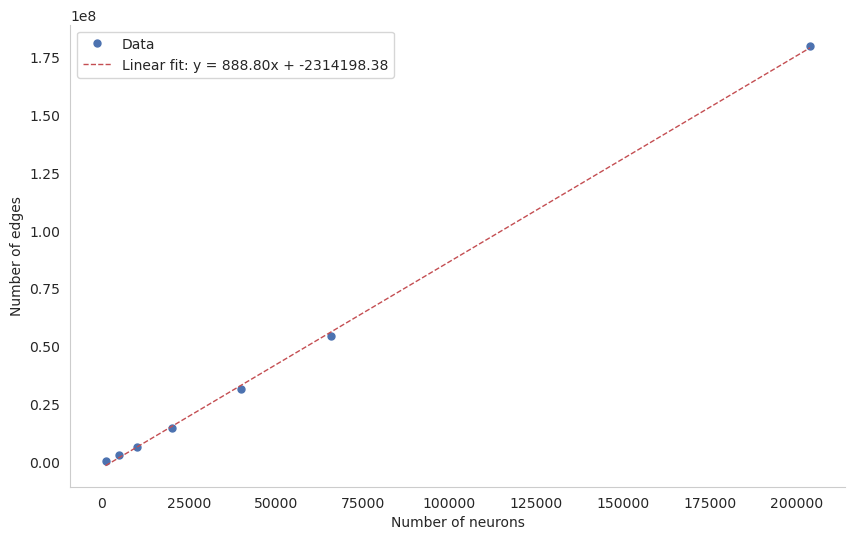

In [13]:
edges = df['n_edges']#.unique()
neurons = df['n_neurons']#.unique()
mem = df['mean_gpu_memory']
time = df['mean_step_time']

plt.figure(figsize=(10, 6))
plt.plot(neurons, edges, 'o', markersize=5)

# include a linear fit
# fit a line to the data
z = np.polyfit(neurons, edges, 1)
p = np.poly1d(z)
plt.plot(neurons, p(neurons), 'r--', linewidth=1)
# include a legend with the fit parameters
plt.legend(['Data', 'Linear fit: y = {:.2f}x + {:.2f}'.format(z[0], z[1])], loc='upper left')

plt.xlabel('Number of neurons')
# plt.ylabel('Number of neurons')
plt.ylabel('Number of edges')
# plt.title('Number of edges vs number of neurons')
plt.grid()
plt.show()

In [14]:
0.000149*475000+2.33

73.10499999999999

Number of neurons for 48GB of memory: 283838.32335329347
Number of neurons for 80GB of memory: 475455.08982035925
Number of neurons for 188GB of memory: 840724.5508982037
Memory for 203816 neurons: 34.636272 GB


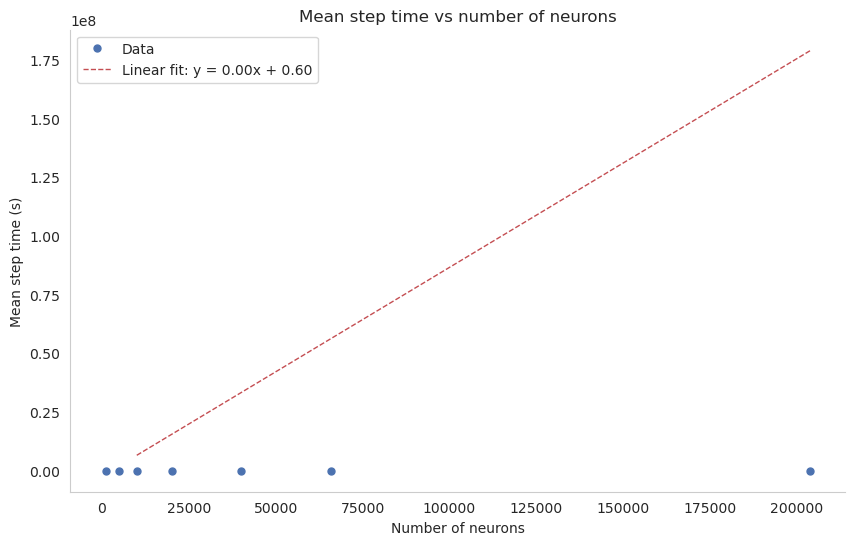

In [15]:
plt.figure(figsize=(10, 6))

# include a linear fit
# fit a line to the data
x = neurons
y = time
plt.plot(x, y, 'o', markersize=5)

# z = np.polyfit(x[2:], y[2:], 1)
z = [0.000167, 0.599]
# p = np.poly1d(z)
plt.plot(x[2:], p(x[2:]), 'r--', linewidth=1)
# include a legend with the fit parameters
plt.legend(['Data', 'Linear fit: y = {:.2f}x + {:.2f}'.format(z[0], z[1])], loc='upper left')

# using this fit, calculate the number of neurons for 48GB, 80GB, 188GB of memory
neurons_for_48GB = (48 - z[1]) / z[0]
print(f'Number of neurons for 48GB of memory: {neurons_for_48GB}')

neurons_for_80GB = (80 - z[1]) / z[0]
print(f'Number of neurons for 80GB of memory: {neurons_for_80GB}')

neurons_for_188GB = (141 - z[1]) / z[0]
print(f'Number of neurons for 188GB of memory: {neurons_for_188GB}')

# calculate the memory for 203816 neurons
sample_neurons = 203816
sample_mem = z[0] * sample_neurons + z[1]
print(f'Memory for {sample_neurons} neurons: {sample_mem} GB')

# convert x axis to logscale
# plt.xscale('log')
plt.xlabel('Number of neurons')
# plt.ylabel('Number of neurons')
plt.ylabel('Mean step time (s)')
plt.title('Mean step time vs number of neurons')
plt.grid()
plt.show()

In [16]:
df

,n_neurons,n_edges,batch_size,seq_len,mean_rate,sem_rate,mean_step_time,sem_step_time,mean_gpu_memory,sem_gpu_memory
0,1000,544263,1.0,1000.0,0.0036,0.0,3.60200,0.01365,2.00505,0.00815
1,5000,3074601,1.0,1000.0,0.0036,0.0,3.82650,0.00505,1.53895,0.00125
2,10000,6645432,1.0,1000.0,0.0035,0.0,3.95835,0.00525,1.90885,0.00080
3,20000,14807994,1.0,1000.0,0.0036,0.0,4.75040,0.00630,3.48880,0.00105
4,40000,31863080,1.0,1000.0,0.0035,0.0,7.05280,0.00785,6.81810,0.00155
5,65871,54378241,1.0,1000.0,0.0036,0.0,11.45240,0.00845,11.29420,0.00260
6,203816,179735332,1.0,1000.0,0.0037,0.0,33.20000,0.01940,34.90000,0.03140
